# ft_sommelier
### *Elementary Machine Learning Project*
![img](https://www.42.us.org/wp-content/uploads/2017/07/logo.png)

In [1]:
import math
import pandas as pd
import matplotlib.pyplot as plt
import random
import copy
from matplotlib.colors import ListedColormap as cm

%matplotlib inline

In [2]:
try:
    wine_data = pd.read_csv('winequality-red copy.csv', sep=';')
except FileNotFoundError:
    print('[-] Choose the correct dataset')


In [3]:
#Exploring the data
wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


# V.1  Exploring the green reds

**a)** Write a **function** that will **plot** a **scatterplot matrix** of your red wine data. 

In [4]:
def plot_scatter_matrix(wine_data, good_threshold, bad_threshold, save_plot=False):
    # 1.Load the variables from the data
    num_vars, num_data = wine_data.shape
    # 2.Assign the names of colomns in a dataset to labels in a matrix
    label = wine_data.columns
    # 3.Create the subplot of the size of the Series
    sub, axes = plt.subplots(nrows=num_data, ncols=num_data, figsize=(35, 35))
    # 4. Remove the x and y axis to get a results as in a PDF
    for ax in axes.flat:
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
    # Remove the spaces
    plt.subplots_adjust(wspace=0.0, hspace=0.0)
    #Place labels as the diagnonal line
    for i, j in enumerate(label):
        axes[i,i].annotate(j, (0.5, 0.5), xycoords='axes fraction', ha='center', va='center')
    # Take only in good_quality the columns where quality is greater than the good_threshold (which is 6)
    good_quality = wine_data[(wine_data['quality'] > good_threshold)]
    # Same for bad quality (5 and lower)
    bad_quality = wine_data[(wine_data['quality'] < bad_threshold)]
    # Fill the subplots with the data
    for i in range(num_data):
        for j in range(i + 1, num_data):
            # Wite twice in order not to overwrite
            axes[i, j].scatter(good_quality.iloc[:, j], good_quality.iloc[:, i], c=['goldenrod'], marker='.')
            axes[i, j].scatter(bad_quality.iloc[:, j], bad_quality.iloc[:, i], c =['mediumslateblue'], marker='.')
            axes[j, i].scatter(good_quality.iloc[:, i], good_quality.iloc[:, j], c =['goldenrod'], marker='.')
            axes[j, i].scatter(bad_quality.iloc[:, i], bad_quality.iloc[:, j], c = ['mediumslateblue'], marker='.')
    plt.show()

A simple sctterplox matrix of our red wine data



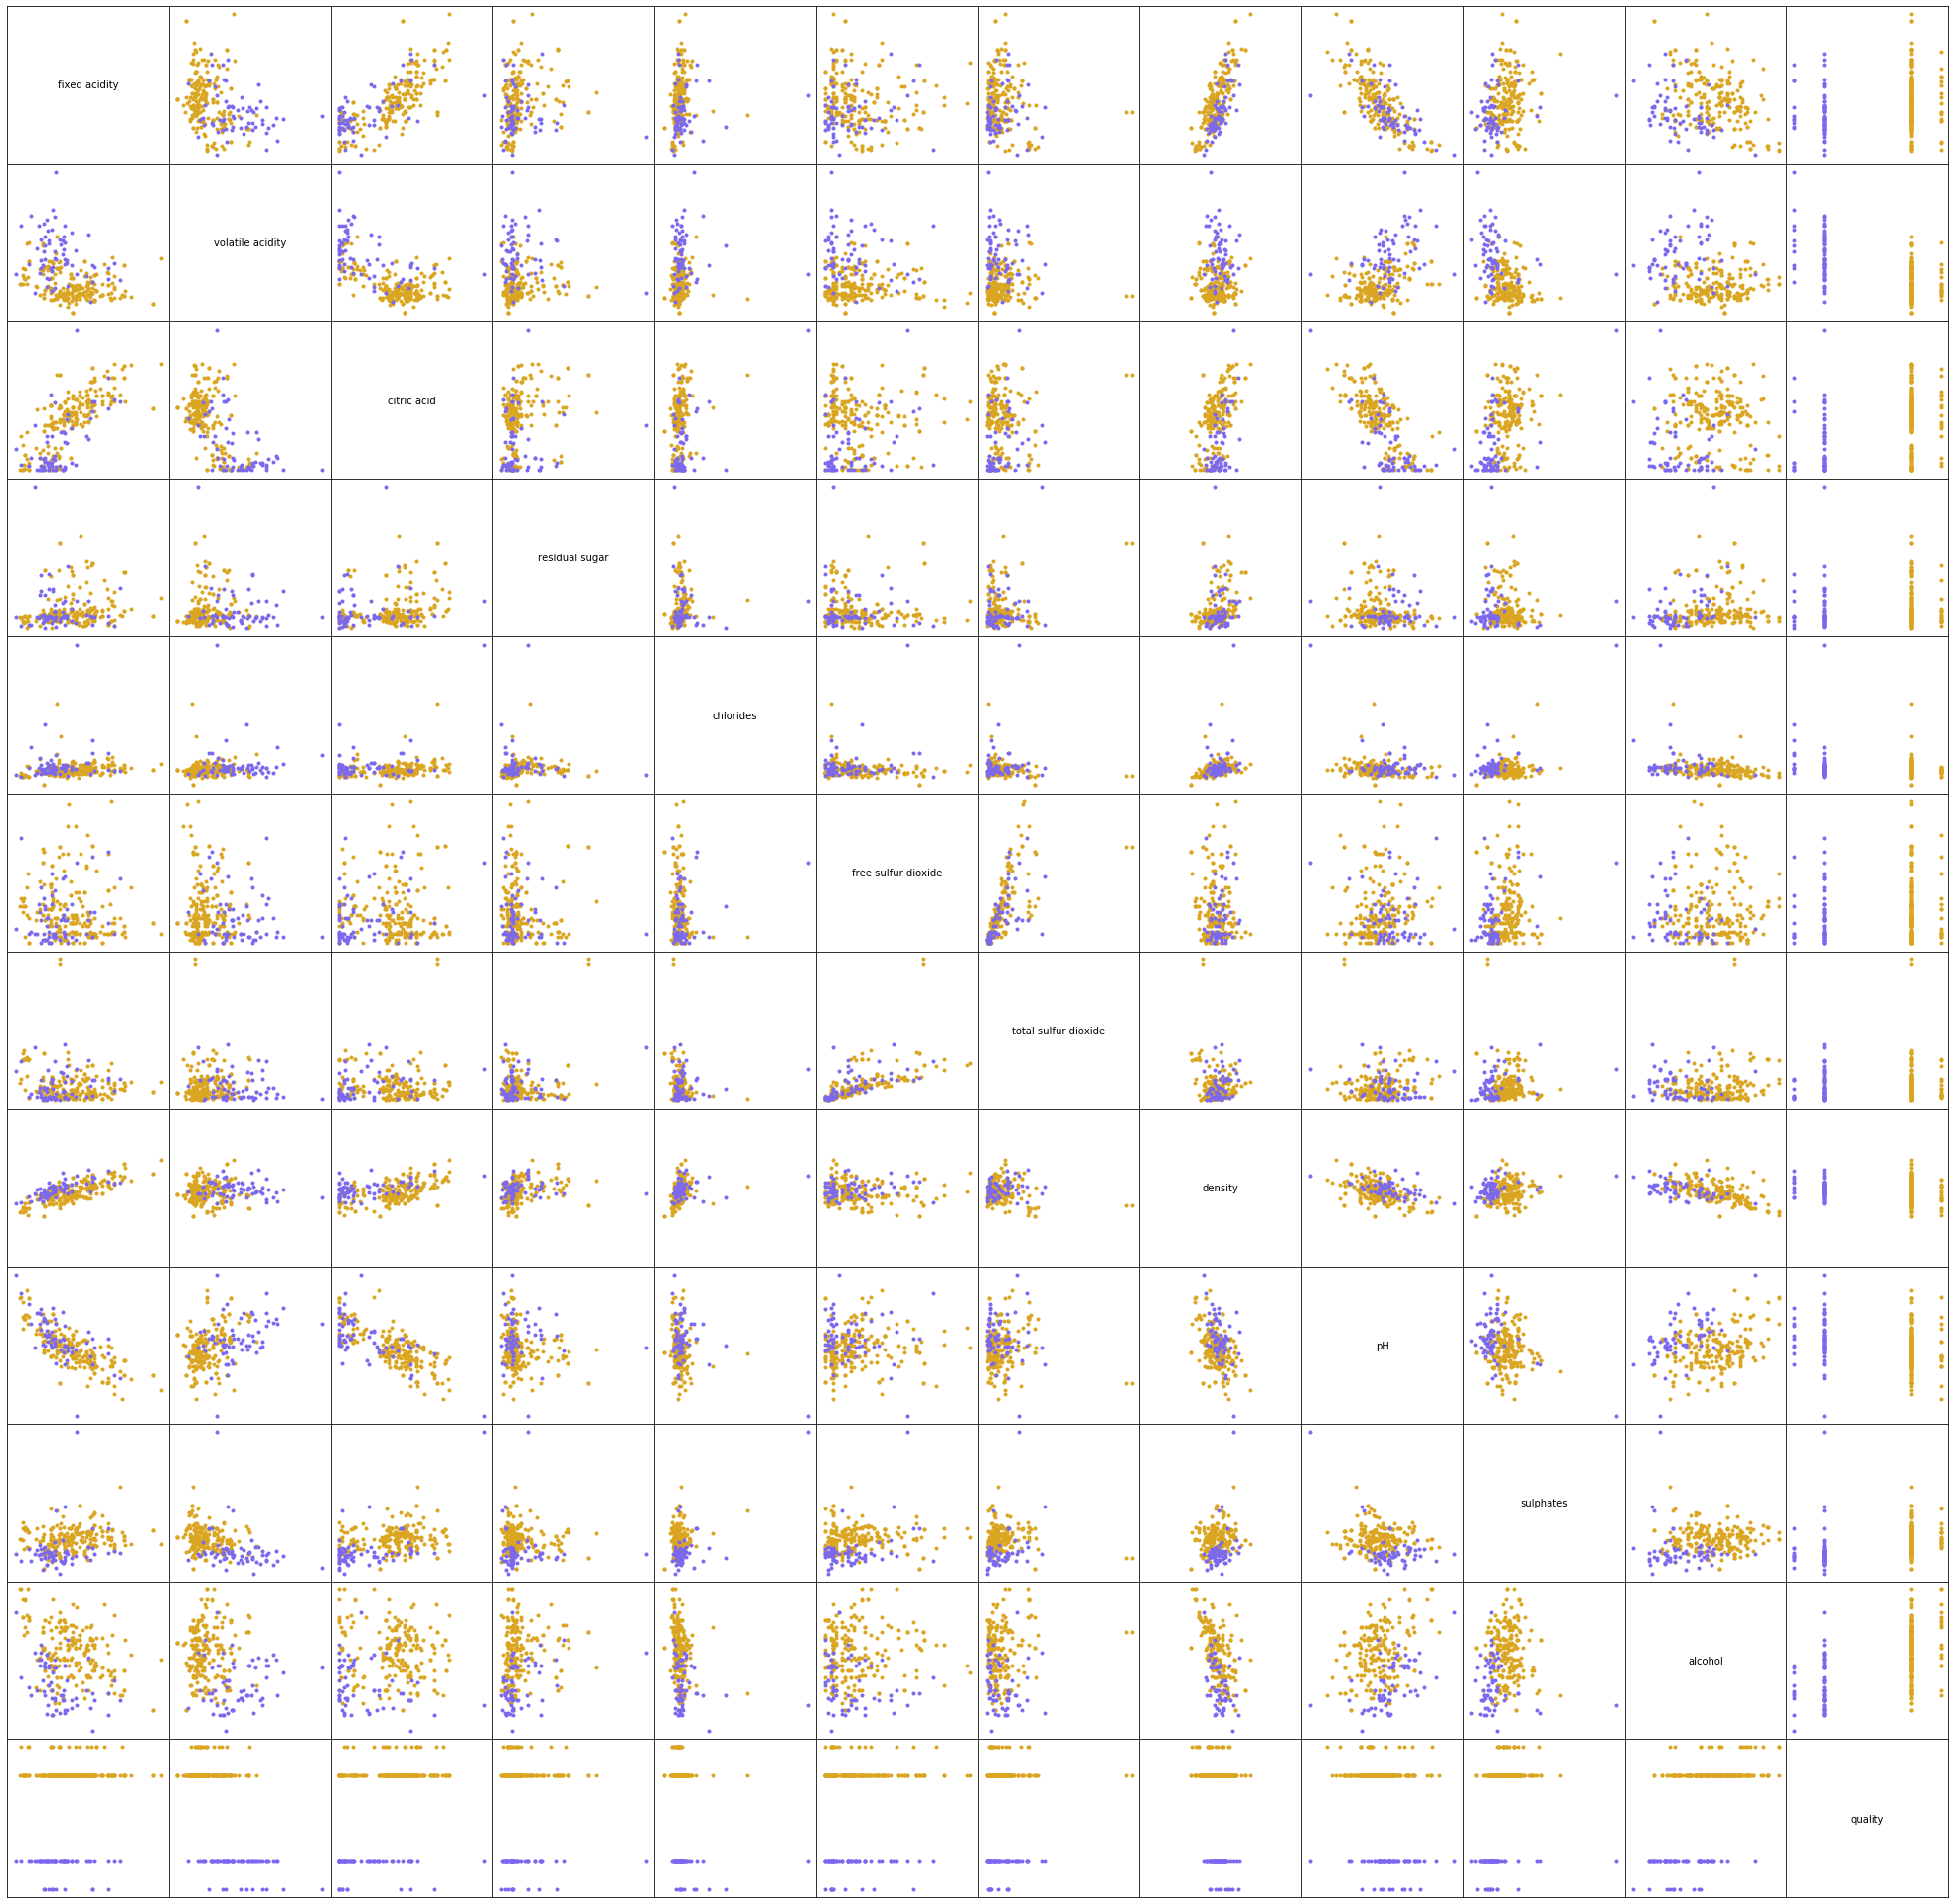

In [5]:
print('A simple sctterplox matrix of our red wine data\n')
plot_scatter_matrix(wine_data, 6, 5, True)


**b)** Which factors will be more useful for distingushing high quality vs. low quality wines?

Judging from the data, **alcohol** and **sulphates** are two of the most useful 
factors when it comes to distinguishing between high quality vs. low quality red wines.If you 
look at the picture, there is a strong correlation and big difference between yellow dots 
and blue dots(good wines and bad wines accordingly).

# V.2 Learning to perceptron

**a)** Implement a perceptron that:
* Has randomly initialized weights and bias
* Uses the Rosenblatt perceptron learning rule
* Utilizes the heavyside step activation function 

**b)** Implement a function to train your perceptron
* Specify the number of training epochs
* Train until it makes no errors
* Specify a learning rate
* Return performance
    
_Perceptron Model_
    
![img_2](https://cdn-images-1.medium.com/max/800/1*LyDp1dru7psq3044D2AXsQ.png)

In [6]:
wine_data = wine_data.assign(goodness=pd.Series(wine_data['quality'] >= 6))

selected_data = wine_data[(wine_data['quality'] >= 8) | (wine_data['quality'] <= 3)][['pH', 'alcohol', 'quality', 'goodness']]
selected_data = selected_data.reset_index(drop=True)

print('We selected {} samples and 2 chemicals factors\n'.format(selected_data.shape[0]))
print(selected_data)

We selected 28 samples and 2 chemicals factors

      pH  alcohol  quality  goodness
0   3.35    12.80        8      True
1   3.23    12.60        8      True
2   3.56    12.90        8      True
3   2.88     9.80        8      True
4   3.22    13.40        8      True
5   3.25     9.00        3     False
6   3.15    11.70        8      True
7   3.15    11.00        8      True
8   3.15    11.00        8      True
9   3.16     8.40        3     False
10  3.72    14.00        8      True
11  3.63    10.70        3     False
12  3.46    12.70        8      True
13  3.38     9.90        3     False
14  3.48    11.00        3     False
15  3.21    12.50        8      True
16  2.98    11.80        8      True
17  3.20    13.10        8      True
18  3.35    11.70        8      True
19  3.50    14.00        8      True
20  3.50    10.90        3     False
21  3.32     9.80        3     False
22  3.23    10.00        8      True
23  3.23    11.30        8      True
24  3.31     9.70        3 

In [7]:
class Perceptron:
    
    def __init__(self, lr):
        self.W = random.random()
        self.lr = lr
        self.performance = list()
    
    #Checking inputs
    def _net_input(self, X):
        if len(self.W[1:]) != len(X):
            raise ValueError('Sorry, invalid arguments')
        result = 0
        for i in range(len(self.W[1:])):
            result += self.W[1:][i] * X[i]
        return result + self.W[0]
    
    #Using the heaviside step function:
    def predict(self, X):
        return 1 if self._net_input(X) > 0.0 else 0
        
    def evaluate_accuracy(self, X, y):
        num_correct = 0

        for xi, yi in zip(X, y):
            num_correct += int(self.predict(xi) == int(yi))
        
        accuracy = num_correct / len(y)
        return accuracy
    
    def _train_epoch(self, X, y, epoch):
        epoch_errors = 0

        for xi, yi in zip(X, y):
            update = self.lr * (yi - self.predict(xi))
            self.W[0] += update
            self.W[1:] += update * xi
            epoch_errors += int(update != 0.0)

        print('Epoch {}, {} errors'.format(epoch, epoch_errors))
        self.performance.append((epoch, epoch_errors, self.W[1:], self.W[0]))
        
        return epoch_errors
    
    def train(self, X, y, epochs):
        if epochs < 0:
            raise ValueError('An invalid number of training epochs')
        # if self.W is None:
        self.W = [0.0001 * random.uniform(-1, 1) for i in range(X.shape[1] + 1)]

        epoch = 0
        while True:
            epoch_errors = self._train_epoch(X, y, epoch)
            epoch += 1
            if epochs != 0 and epoch == epochs:
                break
            elif epochs == 0 and epoch_errors == 0:
                break
        
        return self.performance

In [8]:
X = selected_data.loc[:, ['pH', 'alcohol']]
Y = selected_data['goodness'].values

#Learning rate determines how fast or slow we will move towards the optimal weights.

p = Perceptron(lr=0.008)
train_process = p.train(X.values, Y, 14000)

Epoch 0, 13 errors
Epoch 1, 13 errors
Epoch 2, 11 errors
Epoch 3, 11 errors
Epoch 4, 13 errors
Epoch 5, 11 errors
Epoch 6, 9 errors
Epoch 7, 2 errors
Epoch 8, 6 errors
Epoch 9, 13 errors
Epoch 10, 7 errors
Epoch 11, 4 errors
Epoch 12, 6 errors
Epoch 13, 9 errors
Epoch 14, 2 errors
Epoch 15, 2 errors
Epoch 16, 4 errors
Epoch 17, 6 errors
Epoch 18, 9 errors
Epoch 19, 2 errors
Epoch 20, 2 errors
Epoch 21, 4 errors
Epoch 22, 6 errors
Epoch 23, 7 errors
Epoch 24, 4 errors
Epoch 25, 2 errors
Epoch 26, 4 errors
Epoch 27, 6 errors
Epoch 28, 8 errors
Epoch 29, 9 errors
Epoch 30, 8 errors
Epoch 31, 5 errors
Epoch 32, 4 errors
Epoch 33, 4 errors
Epoch 34, 6 errors
Epoch 35, 8 errors
Epoch 36, 7 errors
Epoch 37, 4 errors
Epoch 38, 6 errors
Epoch 39, 8 errors
Epoch 40, 7 errors
Epoch 41, 4 errors
Epoch 42, 6 errors
Epoch 43, 8 errors
Epoch 44, 3 errors
Epoch 45, 4 errors
Epoch 46, 2 errors
Epoch 47, 2 errors
Epoch 48, 2 errors
Epoch 49, 2 errors
Epoch 50, 4 errors
Epoch 51, 4 errors
Epoch 52, 6 err

Epoch 424, 4 errors
Epoch 425, 4 errors
Epoch 426, 4 errors
Epoch 427, 4 errors
Epoch 428, 4 errors
Epoch 429, 4 errors
Epoch 430, 4 errors
Epoch 431, 4 errors
Epoch 432, 4 errors
Epoch 433, 4 errors
Epoch 434, 4 errors
Epoch 435, 4 errors
Epoch 436, 4 errors
Epoch 437, 4 errors
Epoch 438, 4 errors
Epoch 439, 4 errors
Epoch 440, 4 errors
Epoch 441, 4 errors
Epoch 442, 4 errors
Epoch 443, 4 errors
Epoch 444, 4 errors
Epoch 445, 4 errors
Epoch 446, 4 errors
Epoch 447, 4 errors
Epoch 448, 4 errors
Epoch 449, 4 errors
Epoch 450, 4 errors
Epoch 451, 4 errors
Epoch 452, 4 errors
Epoch 453, 4 errors
Epoch 454, 4 errors
Epoch 455, 4 errors
Epoch 456, 4 errors
Epoch 457, 4 errors
Epoch 458, 4 errors
Epoch 459, 4 errors
Epoch 460, 4 errors
Epoch 461, 4 errors
Epoch 462, 4 errors
Epoch 463, 4 errors
Epoch 464, 4 errors
Epoch 465, 4 errors
Epoch 466, 4 errors
Epoch 467, 4 errors
Epoch 468, 4 errors
Epoch 469, 4 errors
Epoch 470, 4 errors
Epoch 471, 4 errors
Epoch 472, 4 errors
Epoch 473, 4 errors


Epoch 873, 2 errors
Epoch 874, 2 errors
Epoch 875, 2 errors
Epoch 876, 2 errors
Epoch 877, 2 errors
Epoch 878, 2 errors
Epoch 879, 2 errors
Epoch 880, 2 errors
Epoch 881, 2 errors
Epoch 882, 2 errors
Epoch 883, 2 errors
Epoch 884, 2 errors
Epoch 885, 2 errors
Epoch 886, 2 errors
Epoch 887, 2 errors
Epoch 888, 2 errors
Epoch 889, 2 errors
Epoch 890, 2 errors
Epoch 891, 2 errors
Epoch 892, 2 errors
Epoch 893, 2 errors
Epoch 894, 2 errors
Epoch 895, 2 errors
Epoch 896, 2 errors
Epoch 897, 2 errors
Epoch 898, 2 errors
Epoch 899, 2 errors
Epoch 900, 2 errors
Epoch 901, 2 errors
Epoch 902, 2 errors
Epoch 903, 2 errors
Epoch 904, 2 errors
Epoch 905, 2 errors
Epoch 906, 2 errors
Epoch 907, 2 errors
Epoch 908, 2 errors
Epoch 909, 2 errors
Epoch 910, 2 errors
Epoch 911, 2 errors
Epoch 912, 2 errors
Epoch 913, 2 errors
Epoch 914, 2 errors
Epoch 915, 2 errors
Epoch 916, 1 errors
Epoch 917, 2 errors
Epoch 918, 2 errors
Epoch 919, 2 errors
Epoch 920, 2 errors
Epoch 921, 2 errors
Epoch 922, 2 errors


Epoch 1292, 2 errors
Epoch 1293, 2 errors
Epoch 1294, 2 errors
Epoch 1295, 2 errors
Epoch 1296, 2 errors
Epoch 1297, 2 errors
Epoch 1298, 2 errors
Epoch 1299, 2 errors
Epoch 1300, 2 errors
Epoch 1301, 2 errors
Epoch 1302, 2 errors
Epoch 1303, 2 errors
Epoch 1304, 2 errors
Epoch 1305, 2 errors
Epoch 1306, 2 errors
Epoch 1307, 2 errors
Epoch 1308, 2 errors
Epoch 1309, 1 errors
Epoch 1310, 2 errors
Epoch 1311, 2 errors
Epoch 1312, 2 errors
Epoch 1313, 2 errors
Epoch 1314, 2 errors
Epoch 1315, 2 errors
Epoch 1316, 2 errors
Epoch 1317, 2 errors
Epoch 1318, 2 errors
Epoch 1319, 2 errors
Epoch 1320, 2 errors
Epoch 1321, 2 errors
Epoch 1322, 2 errors
Epoch 1323, 2 errors
Epoch 1324, 2 errors
Epoch 1325, 2 errors
Epoch 1326, 2 errors
Epoch 1327, 2 errors
Epoch 1328, 2 errors
Epoch 1329, 2 errors
Epoch 1330, 2 errors
Epoch 1331, 2 errors
Epoch 1332, 1 errors
Epoch 1333, 2 errors
Epoch 1334, 2 errors
Epoch 1335, 2 errors
Epoch 1336, 2 errors
Epoch 1337, 2 errors
Epoch 1338, 2 errors
Epoch 1339, 2

Epoch 1740, 2 errors
Epoch 1741, 2 errors
Epoch 1742, 2 errors
Epoch 1743, 2 errors
Epoch 1744, 2 errors
Epoch 1745, 2 errors
Epoch 1746, 2 errors
Epoch 1747, 2 errors
Epoch 1748, 2 errors
Epoch 1749, 2 errors
Epoch 1750, 2 errors
Epoch 1751, 2 errors
Epoch 1752, 2 errors
Epoch 1753, 2 errors
Epoch 1754, 2 errors
Epoch 1755, 2 errors
Epoch 1756, 1 errors
Epoch 1757, 2 errors
Epoch 1758, 2 errors
Epoch 1759, 2 errors
Epoch 1760, 2 errors
Epoch 1761, 2 errors
Epoch 1762, 2 errors
Epoch 1763, 2 errors
Epoch 1764, 2 errors
Epoch 1765, 2 errors
Epoch 1766, 2 errors
Epoch 1767, 2 errors
Epoch 1768, 2 errors
Epoch 1769, 2 errors
Epoch 1770, 2 errors
Epoch 1771, 2 errors
Epoch 1772, 2 errors
Epoch 1773, 2 errors
Epoch 1774, 2 errors
Epoch 1775, 2 errors
Epoch 1776, 2 errors
Epoch 1777, 2 errors
Epoch 1778, 2 errors
Epoch 1779, 1 errors
Epoch 1780, 2 errors
Epoch 1781, 2 errors
Epoch 1782, 2 errors
Epoch 1783, 2 errors
Epoch 1784, 2 errors
Epoch 1785, 2 errors
Epoch 1786, 2 errors
Epoch 1787, 2

Epoch 2360, 2 errors
Epoch 2361, 2 errors
Epoch 2362, 2 errors
Epoch 2363, 2 errors
Epoch 2364, 2 errors
Epoch 2365, 2 errors
Epoch 2366, 2 errors
Epoch 2367, 2 errors
Epoch 2368, 2 errors
Epoch 2369, 1 errors
Epoch 2370, 2 errors
Epoch 2371, 2 errors
Epoch 2372, 2 errors
Epoch 2373, 2 errors
Epoch 2374, 2 errors
Epoch 2375, 2 errors
Epoch 2376, 2 errors
Epoch 2377, 2 errors
Epoch 2378, 2 errors
Epoch 2379, 2 errors
Epoch 2380, 2 errors
Epoch 2381, 2 errors
Epoch 2382, 2 errors
Epoch 2383, 2 errors
Epoch 2384, 2 errors
Epoch 2385, 2 errors
Epoch 2386, 2 errors
Epoch 2387, 2 errors
Epoch 2388, 2 errors
Epoch 2389, 2 errors
Epoch 2390, 2 errors
Epoch 2391, 1 errors
Epoch 2392, 2 errors
Epoch 2393, 2 errors
Epoch 2394, 2 errors
Epoch 2395, 2 errors
Epoch 2396, 2 errors
Epoch 2397, 2 errors
Epoch 2398, 2 errors
Epoch 2399, 2 errors
Epoch 2400, 2 errors
Epoch 2401, 2 errors
Epoch 2402, 2 errors
Epoch 2403, 2 errors
Epoch 2404, 2 errors
Epoch 2405, 2 errors
Epoch 2406, 2 errors
Epoch 2407, 2

Epoch 2879, 2 errors
Epoch 2880, 2 errors
Epoch 2881, 2 errors
Epoch 2882, 2 errors
Epoch 2883, 2 errors
Epoch 2884, 2 errors
Epoch 2885, 2 errors
Epoch 2886, 2 errors
Epoch 2887, 1 errors
Epoch 2888, 2 errors
Epoch 2889, 2 errors
Epoch 2890, 2 errors
Epoch 2891, 2 errors
Epoch 2892, 2 errors
Epoch 2893, 2 errors
Epoch 2894, 2 errors
Epoch 2895, 2 errors
Epoch 2896, 2 errors
Epoch 2897, 2 errors
Epoch 2898, 2 errors
Epoch 2899, 2 errors
Epoch 2900, 2 errors
Epoch 2901, 2 errors
Epoch 2902, 2 errors
Epoch 2903, 2 errors
Epoch 2904, 2 errors
Epoch 2905, 2 errors
Epoch 2906, 2 errors
Epoch 2907, 2 errors
Epoch 2908, 2 errors
Epoch 2909, 1 errors
Epoch 2910, 2 errors
Epoch 2911, 2 errors
Epoch 2912, 2 errors
Epoch 2913, 2 errors
Epoch 2914, 2 errors
Epoch 2915, 2 errors
Epoch 2916, 2 errors
Epoch 2917, 2 errors
Epoch 2918, 2 errors
Epoch 2919, 2 errors
Epoch 2920, 2 errors
Epoch 2921, 2 errors
Epoch 2922, 2 errors
Epoch 2923, 2 errors
Epoch 2924, 2 errors
Epoch 2925, 2 errors
Epoch 2926, 2

Epoch 3565, 2 errors
Epoch 3566, 2 errors
Epoch 3567, 1 errors
Epoch 3568, 2 errors
Epoch 3569, 2 errors
Epoch 3570, 2 errors
Epoch 3571, 2 errors
Epoch 3572, 2 errors
Epoch 3573, 2 errors
Epoch 3574, 2 errors
Epoch 3575, 2 errors
Epoch 3576, 2 errors
Epoch 3577, 2 errors
Epoch 3578, 2 errors
Epoch 3579, 2 errors
Epoch 3580, 2 errors
Epoch 3581, 2 errors
Epoch 3582, 2 errors
Epoch 3583, 2 errors
Epoch 3584, 2 errors
Epoch 3585, 2 errors
Epoch 3586, 1 errors
Epoch 3587, 2 errors
Epoch 3588, 2 errors
Epoch 3589, 2 errors
Epoch 3590, 2 errors
Epoch 3591, 2 errors
Epoch 3592, 2 errors
Epoch 3593, 2 errors
Epoch 3594, 2 errors
Epoch 3595, 2 errors
Epoch 3596, 2 errors
Epoch 3597, 2 errors
Epoch 3598, 2 errors
Epoch 3599, 2 errors
Epoch 3600, 2 errors
Epoch 3601, 2 errors
Epoch 3602, 2 errors
Epoch 3603, 2 errors
Epoch 3604, 1 errors
Epoch 3605, 2 errors
Epoch 3606, 2 errors
Epoch 3607, 2 errors
Epoch 3608, 2 errors
Epoch 3609, 2 errors
Epoch 3610, 2 errors
Epoch 3611, 2 errors
Epoch 3612, 2

Epoch 4268, 2 errors
Epoch 4269, 2 errors
Epoch 4270, 2 errors
Epoch 4271, 2 errors
Epoch 4272, 2 errors
Epoch 4273, 2 errors
Epoch 4274, 2 errors
Epoch 4275, 2 errors
Epoch 4276, 2 errors
Epoch 4277, 2 errors
Epoch 4278, 2 errors
Epoch 4279, 2 errors
Epoch 4280, 1 errors
Epoch 4281, 2 errors
Epoch 4282, 2 errors
Epoch 4283, 2 errors
Epoch 4284, 2 errors
Epoch 4285, 2 errors
Epoch 4286, 2 errors
Epoch 4287, 2 errors
Epoch 4288, 2 errors
Epoch 4289, 2 errors
Epoch 4290, 2 errors
Epoch 4291, 2 errors
Epoch 4292, 2 errors
Epoch 4293, 2 errors
Epoch 4294, 2 errors
Epoch 4295, 2 errors
Epoch 4296, 2 errors
Epoch 4297, 2 errors
Epoch 4298, 2 errors
Epoch 4299, 1 errors
Epoch 4300, 2 errors
Epoch 4301, 2 errors
Epoch 4302, 2 errors
Epoch 4303, 2 errors
Epoch 4304, 2 errors
Epoch 4305, 2 errors
Epoch 4306, 2 errors
Epoch 4307, 2 errors
Epoch 4308, 2 errors
Epoch 4309, 2 errors
Epoch 4310, 2 errors
Epoch 4311, 2 errors
Epoch 4312, 2 errors
Epoch 4313, 2 errors
Epoch 4314, 2 errors
Epoch 4315, 2

Epoch 4925, 2 errors
Epoch 4926, 2 errors
Epoch 4927, 2 errors
Epoch 4928, 2 errors
Epoch 4929, 2 errors
Epoch 4930, 2 errors
Epoch 4931, 2 errors
Epoch 4932, 2 errors
Epoch 4933, 2 errors
Epoch 4934, 2 errors
Epoch 4935, 2 errors
Epoch 4936, 2 errors
Epoch 4937, 1 errors
Epoch 4938, 2 errors
Epoch 4939, 2 errors
Epoch 4940, 2 errors
Epoch 4941, 2 errors
Epoch 4942, 2 errors
Epoch 4943, 2 errors
Epoch 4944, 2 errors
Epoch 4945, 2 errors
Epoch 4946, 2 errors
Epoch 4947, 2 errors
Epoch 4948, 2 errors
Epoch 4949, 2 errors
Epoch 4950, 2 errors
Epoch 4951, 2 errors
Epoch 4952, 2 errors
Epoch 4953, 2 errors
Epoch 4954, 2 errors
Epoch 4955, 2 errors
Epoch 4956, 1 errors
Epoch 4957, 2 errors
Epoch 4958, 2 errors
Epoch 4959, 2 errors
Epoch 4960, 2 errors
Epoch 4961, 2 errors
Epoch 4962, 2 errors
Epoch 4963, 2 errors
Epoch 4964, 2 errors
Epoch 4965, 2 errors
Epoch 4966, 2 errors
Epoch 4967, 2 errors
Epoch 4968, 2 errors
Epoch 4969, 2 errors
Epoch 4970, 2 errors
Epoch 4971, 2 errors
Epoch 4972, 2

Epoch 5588, 2 errors
Epoch 5589, 2 errors
Epoch 5590, 2 errors
Epoch 5591, 2 errors
Epoch 5592, 2 errors
Epoch 5593, 2 errors
Epoch 5594, 1 errors
Epoch 5595, 2 errors
Epoch 5596, 2 errors
Epoch 5597, 2 errors
Epoch 5598, 2 errors
Epoch 5599, 2 errors
Epoch 5600, 2 errors
Epoch 5601, 2 errors
Epoch 5602, 2 errors
Epoch 5603, 2 errors
Epoch 5604, 2 errors
Epoch 5605, 2 errors
Epoch 5606, 2 errors
Epoch 5607, 2 errors
Epoch 5608, 2 errors
Epoch 5609, 2 errors
Epoch 5610, 2 errors
Epoch 5611, 2 errors
Epoch 5612, 2 errors
Epoch 5613, 1 errors
Epoch 5614, 2 errors
Epoch 5615, 2 errors
Epoch 5616, 2 errors
Epoch 5617, 2 errors
Epoch 5618, 2 errors
Epoch 5619, 2 errors
Epoch 5620, 2 errors
Epoch 5621, 2 errors
Epoch 5622, 2 errors
Epoch 5623, 2 errors
Epoch 5624, 2 errors
Epoch 5625, 2 errors
Epoch 5626, 2 errors
Epoch 5627, 2 errors
Epoch 5628, 2 errors
Epoch 5629, 2 errors
Epoch 5630, 2 errors
Epoch 5631, 2 errors
Epoch 5632, 1 errors
Epoch 5633, 2 errors
Epoch 5634, 2 errors
Epoch 5635, 2

Epoch 6290, 2 errors
Epoch 6291, 2 errors
Epoch 6292, 2 errors
Epoch 6293, 2 errors
Epoch 6294, 2 errors
Epoch 6295, 2 errors
Epoch 6296, 2 errors
Epoch 6297, 2 errors
Epoch 6298, 2 errors
Epoch 6299, 2 errors
Epoch 6300, 2 errors
Epoch 6301, 2 errors
Epoch 6302, 2 errors
Epoch 6303, 2 errors
Epoch 6304, 2 errors
Epoch 6305, 2 errors
Epoch 6306, 2 errors
Epoch 6307, 2 errors
Epoch 6308, 1 errors
Epoch 6309, 2 errors
Epoch 6310, 2 errors
Epoch 6311, 2 errors
Epoch 6312, 2 errors
Epoch 6313, 2 errors
Epoch 6314, 2 errors
Epoch 6315, 2 errors
Epoch 6316, 2 errors
Epoch 6317, 2 errors
Epoch 6318, 2 errors
Epoch 6319, 2 errors
Epoch 6320, 2 errors
Epoch 6321, 2 errors
Epoch 6322, 2 errors
Epoch 6323, 2 errors
Epoch 6324, 2 errors
Epoch 6325, 2 errors
Epoch 6326, 1 errors
Epoch 6327, 2 errors
Epoch 6328, 2 errors
Epoch 6329, 2 errors
Epoch 6330, 2 errors
Epoch 6331, 2 errors
Epoch 6332, 2 errors
Epoch 6333, 2 errors
Epoch 6334, 2 errors
Epoch 6335, 2 errors
Epoch 6336, 2 errors
Epoch 6337, 2

Epoch 6702, 1 errors
Epoch 6703, 2 errors
Epoch 6704, 2 errors
Epoch 6705, 2 errors
Epoch 6706, 2 errors
Epoch 6707, 2 errors
Epoch 6708, 2 errors
Epoch 6709, 2 errors
Epoch 6710, 2 errors
Epoch 6711, 2 errors
Epoch 6712, 2 errors
Epoch 6713, 2 errors
Epoch 6714, 2 errors
Epoch 6715, 2 errors
Epoch 6716, 2 errors
Epoch 6717, 2 errors
Epoch 6718, 2 errors
Epoch 6719, 2 errors
Epoch 6720, 2 errors
Epoch 6721, 1 errors
Epoch 6722, 2 errors
Epoch 6723, 2 errors
Epoch 6724, 2 errors
Epoch 6725, 2 errors
Epoch 6726, 2 errors
Epoch 6727, 2 errors
Epoch 6728, 2 errors
Epoch 6729, 2 errors
Epoch 6730, 2 errors
Epoch 6731, 2 errors
Epoch 6732, 2 errors
Epoch 6733, 2 errors
Epoch 6734, 2 errors
Epoch 6735, 2 errors
Epoch 6736, 2 errors
Epoch 6737, 2 errors
Epoch 6738, 2 errors
Epoch 6739, 1 errors
Epoch 6740, 2 errors
Epoch 6741, 2 errors
Epoch 6742, 2 errors
Epoch 6743, 2 errors
Epoch 6744, 2 errors
Epoch 6745, 2 errors
Epoch 6746, 2 errors
Epoch 6747, 2 errors
Epoch 6748, 2 errors
Epoch 6749, 2

Epoch 7343, 2 errors
Epoch 7344, 2 errors
Epoch 7345, 2 errors
Epoch 7346, 2 errors
Epoch 7347, 2 errors
Epoch 7348, 2 errors
Epoch 7349, 2 errors
Epoch 7350, 2 errors
Epoch 7351, 2 errors
Epoch 7352, 2 errors
Epoch 7353, 2 errors
Epoch 7354, 2 errors
Epoch 7355, 2 errors
Epoch 7356, 2 errors
Epoch 7357, 2 errors
Epoch 7358, 2 errors
Epoch 7359, 1 errors
Epoch 7360, 2 errors
Epoch 7361, 2 errors
Epoch 7362, 2 errors
Epoch 7363, 2 errors
Epoch 7364, 2 errors
Epoch 7365, 2 errors
Epoch 7366, 2 errors
Epoch 7367, 2 errors
Epoch 7368, 2 errors
Epoch 7369, 2 errors
Epoch 7370, 2 errors
Epoch 7371, 2 errors
Epoch 7372, 2 errors
Epoch 7373, 2 errors
Epoch 7374, 2 errors
Epoch 7375, 2 errors
Epoch 7376, 2 errors
Epoch 7377, 2 errors
Epoch 7378, 1 errors
Epoch 7379, 2 errors
Epoch 7380, 2 errors
Epoch 7381, 2 errors
Epoch 7382, 2 errors
Epoch 7383, 2 errors
Epoch 7384, 2 errors
Epoch 7385, 2 errors
Epoch 7386, 2 errors
Epoch 7387, 2 errors
Epoch 7388, 2 errors
Epoch 7389, 2 errors
Epoch 7390, 2

Epoch 7807, 2 errors
Epoch 7808, 2 errors
Epoch 7809, 1 errors
Epoch 7810, 2 errors
Epoch 7811, 2 errors
Epoch 7812, 2 errors
Epoch 7813, 2 errors
Epoch 7814, 2 errors
Epoch 7815, 2 errors
Epoch 7816, 2 errors
Epoch 7817, 2 errors
Epoch 7818, 2 errors
Epoch 7819, 2 errors
Epoch 7820, 2 errors
Epoch 7821, 2 errors
Epoch 7822, 2 errors
Epoch 7823, 2 errors
Epoch 7824, 2 errors
Epoch 7825, 2 errors
Epoch 7826, 2 errors
Epoch 7827, 2 errors
Epoch 7828, 1 errors
Epoch 7829, 2 errors
Epoch 7830, 2 errors
Epoch 7831, 2 errors
Epoch 7832, 2 errors
Epoch 7833, 2 errors
Epoch 7834, 2 errors
Epoch 7835, 2 errors
Epoch 7836, 2 errors
Epoch 7837, 2 errors
Epoch 7838, 2 errors
Epoch 7839, 2 errors
Epoch 7840, 2 errors
Epoch 7841, 2 errors
Epoch 7842, 2 errors
Epoch 7843, 2 errors
Epoch 7844, 2 errors
Epoch 7845, 2 errors
Epoch 7846, 2 errors
Epoch 7847, 1 errors
Epoch 7848, 2 errors
Epoch 7849, 2 errors
Epoch 7850, 2 errors
Epoch 7851, 2 errors
Epoch 7852, 2 errors
Epoch 7853, 2 errors
Epoch 7854, 2

Epoch 8428, 2 errors
Epoch 8429, 1 errors
Epoch 8430, 2 errors
Epoch 8431, 2 errors
Epoch 8432, 2 errors
Epoch 8433, 2 errors
Epoch 8434, 2 errors
Epoch 8435, 2 errors
Epoch 8436, 2 errors
Epoch 8437, 2 errors
Epoch 8438, 2 errors
Epoch 8439, 2 errors
Epoch 8440, 2 errors
Epoch 8441, 2 errors
Epoch 8442, 2 errors
Epoch 8443, 2 errors
Epoch 8444, 2 errors
Epoch 8445, 2 errors
Epoch 8446, 2 errors
Epoch 8447, 2 errors
Epoch 8448, 1 errors
Epoch 8449, 2 errors
Epoch 8450, 2 errors
Epoch 8451, 2 errors
Epoch 8452, 2 errors
Epoch 8453, 2 errors
Epoch 8454, 2 errors
Epoch 8455, 2 errors
Epoch 8456, 2 errors
Epoch 8457, 2 errors
Epoch 8458, 2 errors
Epoch 8459, 2 errors
Epoch 8460, 2 errors
Epoch 8461, 2 errors
Epoch 8462, 2 errors
Epoch 8463, 2 errors
Epoch 8464, 2 errors
Epoch 8465, 2 errors
Epoch 8466, 1 errors
Epoch 8467, 2 errors
Epoch 8468, 2 errors
Epoch 8469, 2 errors
Epoch 8470, 2 errors
Epoch 8471, 2 errors
Epoch 8472, 2 errors
Epoch 8473, 2 errors
Epoch 8474, 2 errors
Epoch 8475, 2

Epoch 8919, 2 errors
Epoch 8920, 2 errors
Epoch 8921, 2 errors
Epoch 8922, 2 errors
Epoch 8923, 2 errors
Epoch 8924, 2 errors
Epoch 8925, 2 errors
Epoch 8926, 2 errors
Epoch 8927, 2 errors
Epoch 8928, 2 errors
Epoch 8929, 2 errors
Epoch 8930, 2 errors
Epoch 8931, 2 errors
Epoch 8932, 2 errors
Epoch 8933, 2 errors
Epoch 8934, 2 errors
Epoch 8935, 2 errors
Epoch 8936, 1 errors
Epoch 8937, 2 errors
Epoch 8938, 2 errors
Epoch 8939, 2 errors
Epoch 8940, 2 errors
Epoch 8941, 2 errors
Epoch 8942, 2 errors
Epoch 8943, 2 errors
Epoch 8944, 2 errors
Epoch 8945, 2 errors
Epoch 8946, 2 errors
Epoch 8947, 2 errors
Epoch 8948, 2 errors
Epoch 8949, 2 errors
Epoch 8950, 2 errors
Epoch 8951, 2 errors
Epoch 8952, 2 errors
Epoch 8953, 2 errors
Epoch 8954, 1 errors
Epoch 8955, 2 errors
Epoch 8956, 2 errors
Epoch 8957, 2 errors
Epoch 8958, 2 errors
Epoch 8959, 2 errors
Epoch 8960, 2 errors
Epoch 8961, 2 errors
Epoch 8962, 2 errors
Epoch 8963, 2 errors
Epoch 8964, 2 errors
Epoch 8965, 2 errors
Epoch 8966, 2

Epoch 9802, 2 errors
Epoch 9803, 2 errors
Epoch 9804, 2 errors
Epoch 9805, 2 errors
Epoch 9806, 2 errors
Epoch 9807, 2 errors
Epoch 9808, 2 errors
Epoch 9809, 2 errors
Epoch 9810, 2 errors
Epoch 9811, 2 errors
Epoch 9812, 2 errors
Epoch 9813, 2 errors
Epoch 9814, 2 errors
Epoch 9815, 2 errors
Epoch 9816, 2 errors
Epoch 9817, 2 errors
Epoch 9818, 1 errors
Epoch 9819, 2 errors
Epoch 9820, 2 errors
Epoch 9821, 2 errors
Epoch 9822, 2 errors
Epoch 9823, 2 errors
Epoch 9824, 2 errors
Epoch 9825, 2 errors
Epoch 9826, 2 errors
Epoch 9827, 2 errors
Epoch 9828, 2 errors
Epoch 9829, 2 errors
Epoch 9830, 2 errors
Epoch 9831, 2 errors
Epoch 9832, 2 errors
Epoch 9833, 2 errors
Epoch 9834, 2 errors
Epoch 9835, 2 errors
Epoch 9836, 2 errors
Epoch 9837, 1 errors
Epoch 9838, 2 errors
Epoch 9839, 2 errors
Epoch 9840, 2 errors
Epoch 9841, 2 errors
Epoch 9842, 2 errors
Epoch 9843, 2 errors
Epoch 9844, 2 errors
Epoch 9845, 2 errors
Epoch 9846, 2 errors
Epoch 9847, 2 errors
Epoch 9848, 2 errors
Epoch 9849, 2

Epoch 10267, 2 errors
Epoch 10268, 1 errors
Epoch 10269, 2 errors
Epoch 10270, 2 errors
Epoch 10271, 2 errors
Epoch 10272, 2 errors
Epoch 10273, 2 errors
Epoch 10274, 2 errors
Epoch 10275, 2 errors
Epoch 10276, 2 errors
Epoch 10277, 2 errors
Epoch 10278, 2 errors
Epoch 10279, 2 errors
Epoch 10280, 2 errors
Epoch 10281, 2 errors
Epoch 10282, 2 errors
Epoch 10283, 2 errors
Epoch 10284, 2 errors
Epoch 10285, 2 errors
Epoch 10286, 2 errors
Epoch 10287, 1 errors
Epoch 10288, 2 errors
Epoch 10289, 2 errors
Epoch 10290, 2 errors
Epoch 10291, 2 errors
Epoch 10292, 2 errors
Epoch 10293, 2 errors
Epoch 10294, 2 errors
Epoch 10295, 2 errors
Epoch 10296, 2 errors
Epoch 10297, 2 errors
Epoch 10298, 2 errors
Epoch 10299, 2 errors
Epoch 10300, 2 errors
Epoch 10301, 2 errors
Epoch 10302, 2 errors
Epoch 10303, 2 errors
Epoch 10304, 2 errors
Epoch 10305, 2 errors
Epoch 10306, 1 errors
Epoch 10307, 2 errors
Epoch 10308, 2 errors
Epoch 10309, 2 errors
Epoch 10310, 2 errors
Epoch 10311, 2 errors
Epoch 1031

Epoch 10916, 2 errors
Epoch 10917, 2 errors
Epoch 10918, 2 errors
Epoch 10919, 2 errors
Epoch 10920, 2 errors
Epoch 10921, 2 errors
Epoch 10922, 2 errors
Epoch 10923, 2 errors
Epoch 10924, 2 errors
Epoch 10925, 1 errors
Epoch 10926, 2 errors
Epoch 10927, 2 errors
Epoch 10928, 2 errors
Epoch 10929, 2 errors
Epoch 10930, 2 errors
Epoch 10931, 2 errors
Epoch 10932, 2 errors
Epoch 10933, 2 errors
Epoch 10934, 2 errors
Epoch 10935, 2 errors
Epoch 10936, 2 errors
Epoch 10937, 2 errors
Epoch 10938, 2 errors
Epoch 10939, 2 errors
Epoch 10940, 2 errors
Epoch 10941, 2 errors
Epoch 10942, 2 errors
Epoch 10943, 2 errors
Epoch 10944, 1 errors
Epoch 10945, 2 errors
Epoch 10946, 2 errors
Epoch 10947, 2 errors
Epoch 10948, 2 errors
Epoch 10949, 2 errors
Epoch 10950, 2 errors
Epoch 10951, 2 errors
Epoch 10952, 2 errors
Epoch 10953, 2 errors
Epoch 10954, 2 errors
Epoch 10955, 2 errors
Epoch 10956, 2 errors
Epoch 10957, 2 errors
Epoch 10958, 2 errors
Epoch 10959, 2 errors
Epoch 10960, 2 errors
Epoch 1096

Epoch 11563, 2 errors
Epoch 11564, 1 errors
Epoch 11565, 2 errors
Epoch 11566, 2 errors
Epoch 11567, 2 errors
Epoch 11568, 2 errors
Epoch 11569, 2 errors
Epoch 11570, 2 errors
Epoch 11571, 2 errors
Epoch 11572, 2 errors
Epoch 11573, 2 errors
Epoch 11574, 2 errors
Epoch 11575, 2 errors
Epoch 11576, 2 errors
Epoch 11577, 2 errors
Epoch 11578, 2 errors
Epoch 11579, 2 errors
Epoch 11580, 2 errors
Epoch 11581, 2 errors
Epoch 11582, 1 errors
Epoch 11583, 2 errors
Epoch 11584, 2 errors
Epoch 11585, 2 errors
Epoch 11586, 2 errors
Epoch 11587, 2 errors
Epoch 11588, 2 errors
Epoch 11589, 2 errors
Epoch 11590, 2 errors
Epoch 11591, 2 errors
Epoch 11592, 2 errors
Epoch 11593, 2 errors
Epoch 11594, 2 errors
Epoch 11595, 2 errors
Epoch 11596, 2 errors
Epoch 11597, 2 errors
Epoch 11598, 2 errors
Epoch 11599, 2 errors
Epoch 11600, 2 errors
Epoch 11601, 1 errors
Epoch 11602, 2 errors
Epoch 11603, 2 errors
Epoch 11604, 2 errors
Epoch 11605, 2 errors
Epoch 11606, 2 errors
Epoch 11607, 2 errors
Epoch 1160

Epoch 12382, 2 errors
Epoch 12383, 2 errors
Epoch 12384, 2 errors
Epoch 12385, 2 errors
Epoch 12386, 2 errors
Epoch 12387, 2 errors
Epoch 12388, 2 errors
Epoch 12389, 2 errors
Epoch 12390, 1 errors
Epoch 12391, 2 errors
Epoch 12392, 2 errors
Epoch 12393, 2 errors
Epoch 12394, 2 errors
Epoch 12395, 2 errors
Epoch 12396, 2 errors
Epoch 12397, 2 errors
Epoch 12398, 2 errors
Epoch 12399, 2 errors
Epoch 12400, 2 errors
Epoch 12401, 2 errors
Epoch 12402, 2 errors
Epoch 12403, 2 errors
Epoch 12404, 2 errors
Epoch 12405, 2 errors
Epoch 12406, 2 errors
Epoch 12407, 2 errors
Epoch 12408, 1 errors
Epoch 12409, 2 errors
Epoch 12410, 2 errors
Epoch 12411, 2 errors
Epoch 12412, 2 errors
Epoch 12413, 2 errors
Epoch 12414, 2 errors
Epoch 12415, 2 errors
Epoch 12416, 2 errors
Epoch 12417, 2 errors
Epoch 12418, 2 errors
Epoch 12419, 2 errors
Epoch 12420, 2 errors
Epoch 12421, 2 errors
Epoch 12422, 2 errors
Epoch 12423, 2 errors
Epoch 12424, 2 errors
Epoch 12425, 2 errors
Epoch 12426, 2 errors
Epoch 1242

Epoch 12756, 2 errors
Epoch 12757, 2 errors
Epoch 12758, 2 errors
Epoch 12759, 2 errors
Epoch 12760, 2 errors
Epoch 12761, 2 errors
Epoch 12762, 2 errors
Epoch 12763, 2 errors
Epoch 12764, 2 errors
Epoch 12765, 1 errors
Epoch 12766, 2 errors
Epoch 12767, 2 errors
Epoch 12768, 2 errors
Epoch 12769, 2 errors
Epoch 12770, 2 errors
Epoch 12771, 2 errors
Epoch 12772, 2 errors
Epoch 12773, 2 errors
Epoch 12774, 2 errors
Epoch 12775, 2 errors
Epoch 12776, 2 errors
Epoch 12777, 2 errors
Epoch 12778, 2 errors
Epoch 12779, 2 errors
Epoch 12780, 2 errors
Epoch 12781, 2 errors
Epoch 12782, 2 errors
Epoch 12783, 2 errors
Epoch 12784, 1 errors
Epoch 12785, 2 errors
Epoch 12786, 2 errors
Epoch 12787, 2 errors
Epoch 12788, 2 errors
Epoch 12789, 2 errors
Epoch 12790, 2 errors
Epoch 12791, 2 errors
Epoch 12792, 2 errors
Epoch 12793, 2 errors
Epoch 12794, 2 errors
Epoch 12795, 2 errors
Epoch 12796, 2 errors
Epoch 12797, 2 errors
Epoch 12798, 2 errors
Epoch 12799, 2 errors
Epoch 12800, 2 errors
Epoch 1280

Epoch 13289, 0 errors
Epoch 13290, 0 errors
Epoch 13291, 0 errors
Epoch 13292, 0 errors
Epoch 13293, 0 errors
Epoch 13294, 0 errors
Epoch 13295, 0 errors
Epoch 13296, 0 errors
Epoch 13297, 0 errors
Epoch 13298, 0 errors
Epoch 13299, 0 errors
Epoch 13300, 0 errors
Epoch 13301, 0 errors
Epoch 13302, 0 errors
Epoch 13303, 0 errors
Epoch 13304, 0 errors
Epoch 13305, 0 errors
Epoch 13306, 0 errors
Epoch 13307, 0 errors
Epoch 13308, 0 errors
Epoch 13309, 0 errors
Epoch 13310, 0 errors
Epoch 13311, 0 errors
Epoch 13312, 0 errors
Epoch 13313, 0 errors
Epoch 13314, 0 errors
Epoch 13315, 0 errors
Epoch 13316, 0 errors
Epoch 13317, 0 errors
Epoch 13318, 0 errors
Epoch 13319, 0 errors
Epoch 13320, 0 errors
Epoch 13321, 0 errors
Epoch 13322, 0 errors
Epoch 13323, 0 errors
Epoch 13324, 0 errors
Epoch 13325, 0 errors
Epoch 13326, 0 errors
Epoch 13327, 0 errors
Epoch 13328, 0 errors
Epoch 13329, 0 errors
Epoch 13330, 0 errors
Epoch 13331, 0 errors
Epoch 13332, 0 errors
Epoch 13333, 0 errors
Epoch 1333

Epoch 13912, 0 errors
Epoch 13913, 0 errors
Epoch 13914, 0 errors
Epoch 13915, 0 errors
Epoch 13916, 0 errors
Epoch 13917, 0 errors
Epoch 13918, 0 errors
Epoch 13919, 0 errors
Epoch 13920, 0 errors
Epoch 13921, 0 errors
Epoch 13922, 0 errors
Epoch 13923, 0 errors
Epoch 13924, 0 errors
Epoch 13925, 0 errors
Epoch 13926, 0 errors
Epoch 13927, 0 errors
Epoch 13928, 0 errors
Epoch 13929, 0 errors
Epoch 13930, 0 errors
Epoch 13931, 0 errors
Epoch 13932, 0 errors
Epoch 13933, 0 errors
Epoch 13934, 0 errors
Epoch 13935, 0 errors
Epoch 13936, 0 errors
Epoch 13937, 0 errors
Epoch 13938, 0 errors
Epoch 13939, 0 errors
Epoch 13940, 0 errors
Epoch 13941, 0 errors
Epoch 13942, 0 errors
Epoch 13943, 0 errors
Epoch 13944, 0 errors
Epoch 13945, 0 errors
Epoch 13946, 0 errors
Epoch 13947, 0 errors
Epoch 13948, 0 errors
Epoch 13949, 0 errors
Epoch 13950, 0 errors
Epoch 13951, 0 errors
Epoch 13952, 0 errors
Epoch 13953, 0 errors
Epoch 13954, 0 errors
Epoch 13955, 0 errors
Epoch 13956, 0 errors
Epoch 1395

**c)** Write a function that will take the output of the training func to generate two plots in one figure

In [9]:
def draw_decision_boundary(axes, performance, wine_data, epoch):
    x_min = wine_data.loc[:, 'alcohol'].min() - 0.2
    x_max = wine_data.loc[:, 'alcohol'].max() + 0.2
    y_min = wine_data.loc[:, 'pH'].min()- 0.2
    y_max = wine_data.loc[:, 'pH'].max()+ 0.2
    axes[1].set_title('Decision boundary on epoch: {}'.format(epoch))
    axes[1].set_ylabel(wine_data.columns[0])
    axes[1].set_ylim([y_min, y_max])
    axes[1].set_xlabel(wine_data.columns[1])
    axes[1].set_xlim([x_min, x_max])
    
    w2, w1 = performance[epoch][2]
    b = performance[epoch][3]
    slope = -w1/w2
    intercept = -b/w2
    x_coords = range(int(x_min) - 1, int(x_max) + 2)
    y_coords = slope * x_coords + intercept

    line = axes[1].plot(x_coords, y_coords, 'b--', label='Decision boundary')
    axes[1].fill_between(x_coords, y_coords, y_min, color='#98FB98')
    axes[1].fill_between(x_coords, y_coords, y_max, color='#FA8072')
    
    return line

def draw_scatter(axes, wine_data, good_thresh, bad_thresh):
    good_wines = wine_data[(wine_data['quality'] > good_thresh)]
    bad_wines = wine_data[(wine_data['quality'] < bad_thresh)]

    axes[1].scatter(good_wines.loc[:, 'alcohol'], good_wines.loc[:, 'pH'],
                    c=['g'], label='good wines (> {} score)'.format(good_thresh))
    axes[1].scatter(bad_wines.loc[:, 'alcohol'], bad_wines.loc[:, 'pH'],
                    c=['r'], label='bad wines (< {} score)'.format(bad_thresh))

def plot_performance(performance, wine_data, good_thresh, bad_thresh, epoch = -1, save_plot=False):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    
    if epoch > len(performance) - 1:
        raise ValueError('number of epochs should be less than {}'.format(len(performance)))
    
    if epoch == -1:
        epoch = len(performance) - 1

    # First plot plots the number of errors 
    epochs = [elem[0] for elem in performance]
    epoch_errors = [elem[1] for elem in performance]
    axes[0].plot(epochs, epoch_errors)
    axes[0].set_title('Errors as a function of epochs')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Classification errors')
    
    # The second plots the decision boundary of the perceptron
    line = draw_decision_boundary(axes, performance, wine_data, epoch)
    draw_scatter(axes, wine_data, good_thresh, bad_thresh)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=1)
    
    return fig, line


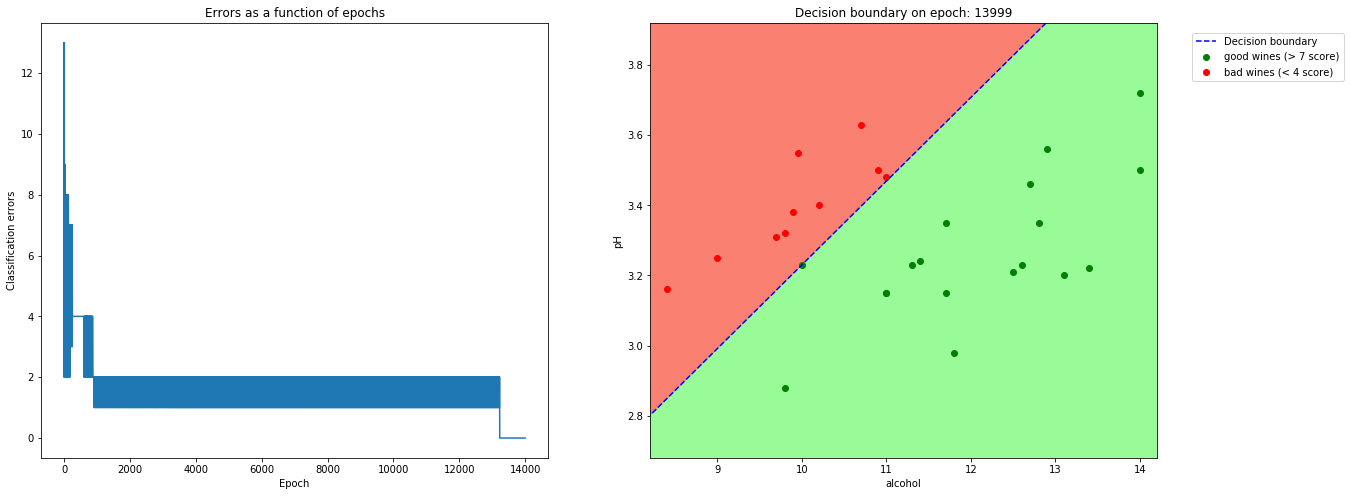

In [10]:
fig = plot_performance(train_process, selected_data, 7, 4, -1, False)
plt.show(fig)

**d)** Feature Scaling

In [11]:
def normalize_data(series):
    return (series - series.mean()) / (series.max() - series.min())

selected_wine_data_norm = copy.deepcopy(selected_data)
selected_wine_data_norm['pH'] = normalize_data(selected_wine_data_norm['pH'])
selected_wine_data_norm['alcohol'] = normalize_data(selected_wine_data_norm['alcohol'])

X = selected_wine_data_norm.loc[:, ['pH', 'alcohol']]
Y = selected_wine_data_norm['goodness'].values

In [12]:
p = Perceptron(lr=0.1)
train_norm_process = p.train(X.values, Y, 40)

Epoch 0, 6 errors
Epoch 1, 4 errors
Epoch 2, 4 errors
Epoch 3, 2 errors
Epoch 4, 2 errors
Epoch 5, 2 errors
Epoch 6, 2 errors
Epoch 7, 2 errors
Epoch 8, 2 errors
Epoch 9, 2 errors
Epoch 10, 2 errors
Epoch 11, 2 errors
Epoch 12, 2 errors
Epoch 13, 2 errors
Epoch 14, 4 errors
Epoch 15, 2 errors
Epoch 16, 2 errors
Epoch 17, 2 errors
Epoch 18, 2 errors
Epoch 19, 2 errors
Epoch 20, 2 errors
Epoch 21, 2 errors
Epoch 22, 2 errors
Epoch 23, 2 errors
Epoch 24, 2 errors
Epoch 25, 2 errors
Epoch 26, 2 errors
Epoch 27, 2 errors
Epoch 28, 2 errors
Epoch 29, 2 errors
Epoch 30, 1 errors
Epoch 31, 3 errors
Epoch 32, 3 errors
Epoch 33, 2 errors
Epoch 34, 3 errors
Epoch 35, 1 errors
Epoch 36, 0 errors
Epoch 37, 0 errors
Epoch 38, 0 errors
Epoch 39, 0 errors


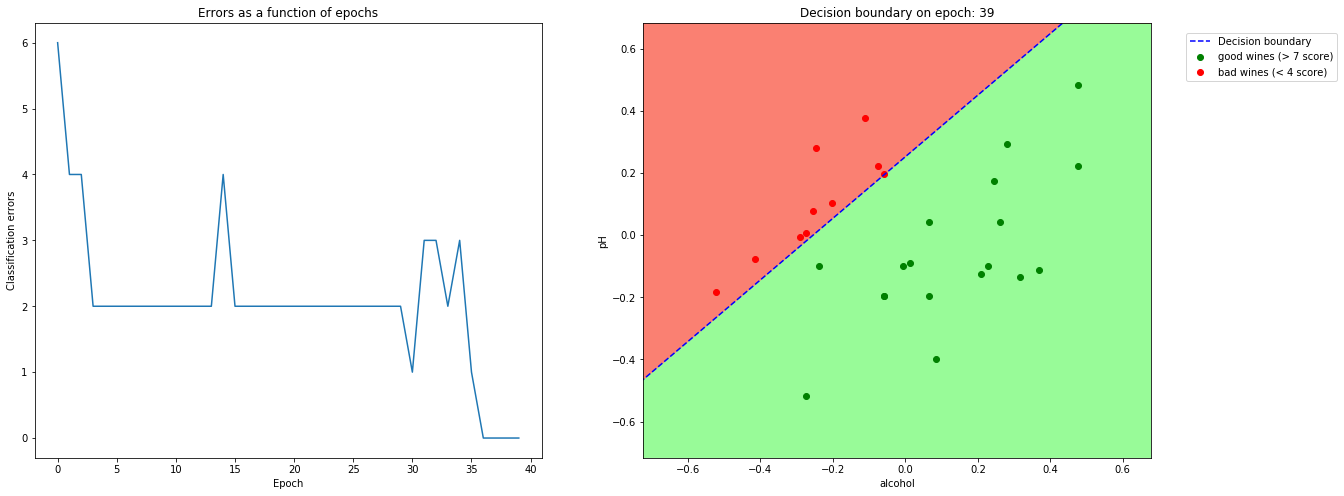

In [13]:
fig = plot_performance(train_norm_process, selected_wine_data_norm, 7, 4, -1, False)
plt.show(fig)

# V.3 My fair ADALINE

**a)** Marvin notices and chides you for torturing your perceptron. Why?

When it comes to solving harder classification tasks, we can't use our peceptron. Single layer 
perceptrons are only capable of learning linearly separable patterns so they can't
distinguishe between wines with a score of 4 and lower, and wines with a score of 7 and higher.

The Perceptron is one of the oldest and simplest learning algorithms out there,
but Adaline is an improvement over the Perceptron. While they both can learn iteratively, 
sample by sample, the Perceptron learns naturally, while Adaline via stochastic gradient descent.

*What is Gradient Descent?*  Gradient descent is an optimization algorithm that finds the optimal 
weights (a,b) that reduces  prediction error.
> A gradient measures how much the output of a function changes if 
> you change the inputs a little bit.

**Main differences:**
* Adaline cost function is Sum Squared Error (SSE) instead of normal error.
* Adaline uses continuous predicted values (from the net input) to learn the model coefficients, 
which is more “powerful” since it tells us by “how much” we were right or wrong.
* ADALINE can calculate the error based on continous values rather than binary value;

![img_3](https://github.com/rasbt/python-machine-learning-book/raw/master/faq/diff-perceptron-adaline-neuralnet/4.png)

In [14]:
selected_data_2 = wine_data[(wine_data['quality'] <= 4) | (wine_data['quality'] >= 7)][['pH', 'alcohol', 'quality', 'goodness']]
selected_data_2 = selected_data_2.reset_index(drop=True)

selected_data_2['pH'] = normalize_data(selected_data_2['pH'])
selected_data_2['alcohol'] = normalize_data(selected_data_2['alcohol'])

print('{} samples selected.\n'.format(X.shape[0]))

28 samples selected.



In [15]:
X = selected_data_2.loc[:, ['pH', 'alcohol']]
Y = selected_data_2['goodness'].values

p = Perceptron(lr=0.05)
train_process_2 = p.train(X.values, Y, 100)

Epoch 0, 55 errors
Epoch 1, 50 errors
Epoch 2, 42 errors
Epoch 3, 40 errors
Epoch 4, 42 errors
Epoch 5, 42 errors
Epoch 6, 44 errors
Epoch 7, 42 errors
Epoch 8, 44 errors
Epoch 9, 42 errors
Epoch 10, 42 errors
Epoch 11, 44 errors
Epoch 12, 42 errors
Epoch 13, 42 errors
Epoch 14, 42 errors
Epoch 15, 42 errors
Epoch 16, 42 errors
Epoch 17, 44 errors
Epoch 18, 42 errors
Epoch 19, 42 errors
Epoch 20, 44 errors
Epoch 21, 42 errors
Epoch 22, 44 errors
Epoch 23, 44 errors
Epoch 24, 42 errors
Epoch 25, 42 errors
Epoch 26, 42 errors
Epoch 27, 42 errors
Epoch 28, 42 errors
Epoch 29, 42 errors
Epoch 30, 44 errors
Epoch 31, 42 errors
Epoch 32, 42 errors
Epoch 33, 44 errors
Epoch 34, 42 errors
Epoch 35, 42 errors
Epoch 36, 42 errors
Epoch 37, 42 errors
Epoch 38, 42 errors
Epoch 39, 42 errors
Epoch 40, 42 errors
Epoch 41, 42 errors
Epoch 42, 44 errors
Epoch 43, 42 errors
Epoch 44, 42 errors
Epoch 45, 42 errors
Epoch 46, 42 errors
Epoch 47, 42 errors
Epoch 48, 44 errors
Epoch 49, 42 errors
Epoch 50, 

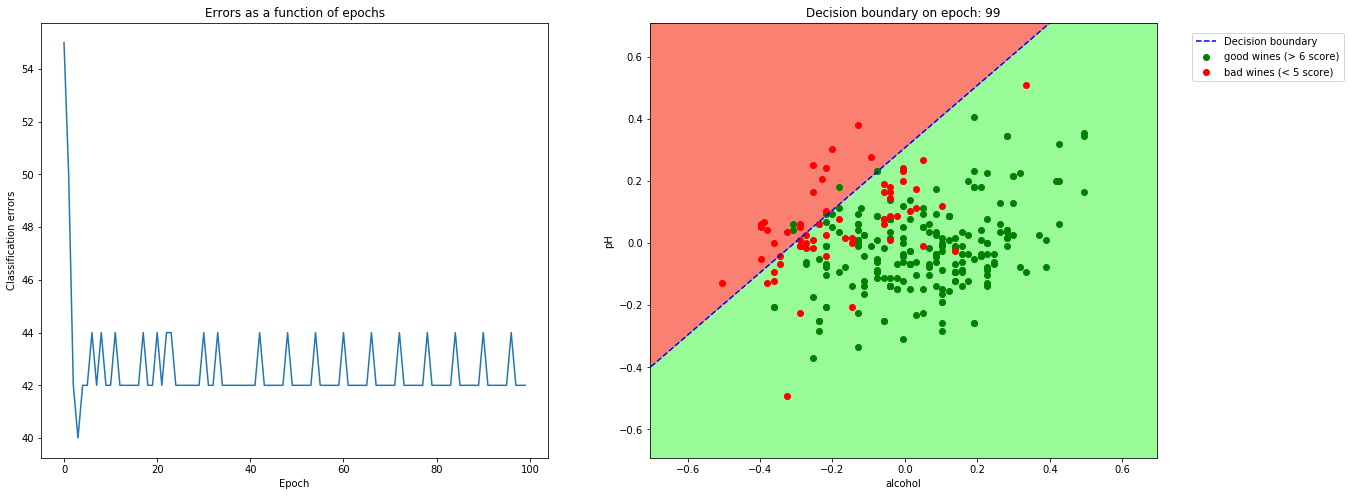

In [16]:
fig = plot_performance(train_process_2, selected_data_2, 6, 5, -1, False)
plt.show(fig)

**b)** Implement an ADALINE (Adaptive Linear Neuron) that:
* Has randomly initialized weights and bias
* Uses a linear activation funcion and quantizer
* Uses the Widrow-Hoff learning rule

In [17]:
def ft_dot(a, b):
    #Dor product of two arrays instead of np.dot
    if len(a) != len(b):
        raise ValueError('arguments have different length')

    result = 0
    for i in range(len(a)):
        result += a[i] * b[i]
    
    return result

class Adaline(object):

    def __init__(self, lr):
        self.W = 0
        self.lr = lr
        self.performance = []

    def _net_input(self, X):
        return ft_dot(self.W[1:], X) + self.W[0]
    
    def _activation_function(self, X):
        net_input = self._net_input(X)
        return 1 / (1 + math.exp(-net_input))
    
    def predict(self, X):
        return 1 if self._activation_function(X) > 0.5 else 0
    
    def evaluate_accuracy(self, X, y):
        num_correct = 0

        for xi, yi in zip(X, y):
            num_correct += int(self.predict(xi) == int(yi))
        
        accuracy = num_correct / len(y)
        print('[.] Model accuracy: {0:.3f}'.format(accuracy))
        
        return accuracy
    
    def _eval_epoch(self, X, y, epoch):
        num_missclass = 0

        for xi, yi in zip(X, y):
            num_missclass += int(self.predict(xi) != int(yi))

        return num_missclass
    
    def _train_epoch(self, X, y, epoch):
        epoch_errors = []

        for xi, yi in zip(X, y):
            error = yi - self._activation_function(xi)
            epoch_errors.append(error)

        self.W[0] += self.lr * sum(epoch_errors)
        self.W[1:] += self.lr * ft_dot(X, epoch_errors)

        num_missclass = self._eval_epoch(X, y, epoch)
        print('Epoch {}, {} errors'.format(epoch, num_missclass))
        self.performance.append((epoch, num_missclass, self.W[1:], self.W[0]))
        
        return epoch_errors

    
    def train(self, X, y, epochs):
        if epochs < 0:
            raise ValueError('invalid number of training epochs')


        if self.W == 0:
            self.W = [0.0001 * random.uniform(-1, 1) for i in range(X.shape[1] + 1)]

        epoch = 0
        while True:
            epoch_errors = self._train_epoch(X, y, epoch)
            epoch += 1
            if epochs != 0 and epoch == epochs:
                break
            elif epochs == 0 and epoch_errors == 0:
                break
        
        return self.performance

#Online: Learning based on each pattern as it is observed.
#Batch: Learning over groups of patters. Most algorithms are batch.

In [25]:
ada = Adaline(lr = 0.08)
train_adaline = ada.train(X.values, Y, 100)

Epoch 0, 63 errors
Epoch 1, 63 errors
Epoch 2, 63 errors
Epoch 3, 43 errors
Epoch 4, 63 errors
Epoch 5, 149 errors
Epoch 6, 63 errors
Epoch 7, 63 errors
Epoch 8, 112 errors
Epoch 9, 63 errors
Epoch 10, 58 errors
Epoch 11, 69 errors
Epoch 12, 63 errors
Epoch 13, 63 errors
Epoch 14, 63 errors
Epoch 15, 77 errors
Epoch 16, 63 errors
Epoch 17, 53 errors
Epoch 18, 59 errors
Epoch 19, 70 errors
Epoch 20, 63 errors
Epoch 21, 62 errors
Epoch 22, 63 errors
Epoch 23, 67 errors
Epoch 24, 63 errors
Epoch 25, 62 errors
Epoch 26, 63 errors
Epoch 27, 65 errors
Epoch 28, 63 errors
Epoch 29, 63 errors
Epoch 30, 61 errors
Epoch 31, 63 errors
Epoch 32, 59 errors
Epoch 33, 61 errors
Epoch 34, 56 errors
Epoch 35, 61 errors
Epoch 36, 55 errors
Epoch 37, 59 errors
Epoch 38, 54 errors
Epoch 39, 58 errors
Epoch 40, 52 errors
Epoch 41, 57 errors
Epoch 42, 52 errors
Epoch 43, 57 errors
Epoch 44, 50 errors
Epoch 45, 56 errors
Epoch 46, 50 errors
Epoch 47, 56 errors
Epoch 48, 50 errors
Epoch 49, 55 errors
Epoch 50

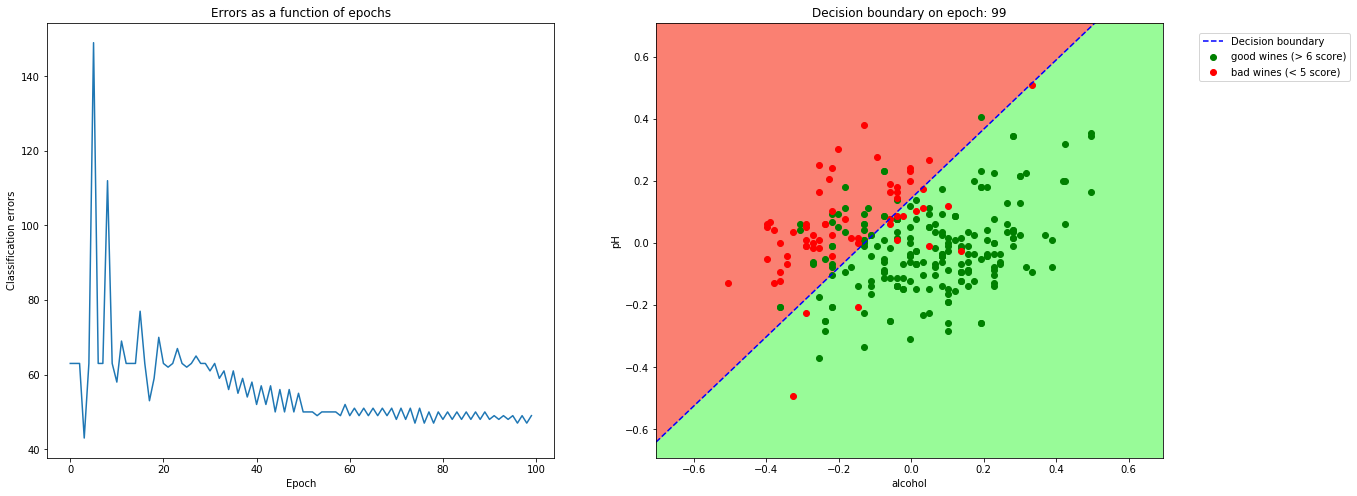

In [26]:
fig = plot_performance(train_adaline, selected_data_2, 6, 5, -1, False)
plt.show(fig)

**d)** Find a good learning rate for your ADALINE and plot number of classification errors
vs. epoch and the decision boundary of your ADALINE. What settings tend to give
the smallest number of classification errors? Support your reasoning with example
plots!

I discovered that learning rate of 0.08 used first time is perfect for the adaline since it's not too big or small and allows adaline to actually learn instead of neither not making a progress at all or making too many mistakes while trying to learn

In [42]:
#Taking a really small lr, adaline learns slowly. With 0.0005 there won't be any progress at all

ada = Adaline(lr = 0.005)
train_adaline = ada.train(X.values, Y, 100)

Epoch 0, 63 errors
Epoch 1, 63 errors
Epoch 2, 63 errors
Epoch 3, 63 errors
Epoch 4, 63 errors
Epoch 5, 63 errors
Epoch 6, 63 errors
Epoch 7, 63 errors
Epoch 8, 63 errors
Epoch 9, 63 errors
Epoch 10, 63 errors
Epoch 11, 63 errors
Epoch 12, 63 errors
Epoch 13, 63 errors
Epoch 14, 63 errors
Epoch 15, 63 errors
Epoch 16, 63 errors
Epoch 17, 63 errors
Epoch 18, 63 errors
Epoch 19, 63 errors
Epoch 20, 63 errors
Epoch 21, 63 errors
Epoch 22, 63 errors
Epoch 23, 63 errors
Epoch 24, 63 errors
Epoch 25, 63 errors
Epoch 26, 63 errors
Epoch 27, 63 errors
Epoch 28, 63 errors
Epoch 29, 63 errors
Epoch 30, 63 errors
Epoch 31, 63 errors
Epoch 32, 63 errors
Epoch 33, 63 errors
Epoch 34, 63 errors
Epoch 35, 63 errors
Epoch 36, 63 errors
Epoch 37, 63 errors
Epoch 38, 63 errors
Epoch 39, 63 errors
Epoch 40, 63 errors
Epoch 41, 63 errors
Epoch 42, 63 errors
Epoch 43, 63 errors
Epoch 44, 63 errors
Epoch 45, 63 errors
Epoch 46, 63 errors
Epoch 47, 63 errors
Epoch 48, 63 errors
Epoch 49, 63 errors
Epoch 50, 

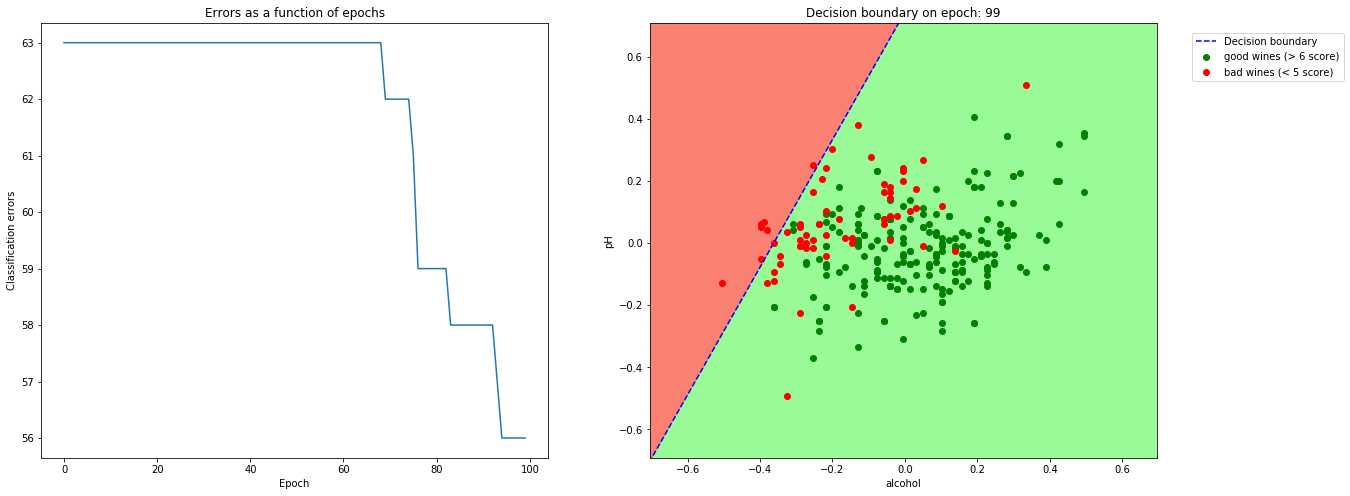

In [43]:
fig = plot_performance(train_adaline, selected_data_2, 6, 5, -1, False)
plt.show(fig)

In [44]:
#Taking a really small lr, adaline learns slowly

ada = Adaline(lr = 0.5)
train_adaline = ada.train(X.values, Y, 100)

Epoch 0, 63 errors
Epoch 1, 63 errors
Epoch 2, 217 errors
Epoch 3, 63 errors
Epoch 4, 63 errors
Epoch 5, 63 errors
Epoch 6, 186 errors
Epoch 7, 63 errors
Epoch 8, 63 errors
Epoch 9, 58 errors
Epoch 10, 148 errors
Epoch 11, 63 errors
Epoch 12, 63 errors
Epoch 13, 71 errors
Epoch 14, 63 errors
Epoch 15, 87 errors
Epoch 16, 63 errors
Epoch 17, 50 errors
Epoch 18, 41 errors
Epoch 19, 64 errors
Epoch 20, 59 errors
Epoch 21, 115 errors
Epoch 22, 63 errors
Epoch 23, 48 errors
Epoch 24, 82 errors
Epoch 25, 63 errors
Epoch 26, 56 errors
Epoch 27, 52 errors
Epoch 28, 92 errors
Epoch 29, 63 errors
Epoch 30, 44 errors
Epoch 31, 39 errors
Epoch 32, 51 errors
Epoch 33, 50 errors
Epoch 34, 94 errors
Epoch 35, 63 errors
Epoch 36, 42 errors
Epoch 37, 38 errors
Epoch 38, 56 errors
Epoch 39, 52 errors
Epoch 40, 96 errors
Epoch 41, 63 errors
Epoch 42, 43 errors
Epoch 43, 42 errors
Epoch 44, 43 errors
Epoch 45, 41 errors
Epoch 46, 40 errors
Epoch 47, 40 errors
Epoch 48, 44 errors
Epoch 49, 47 errors
Epoch 

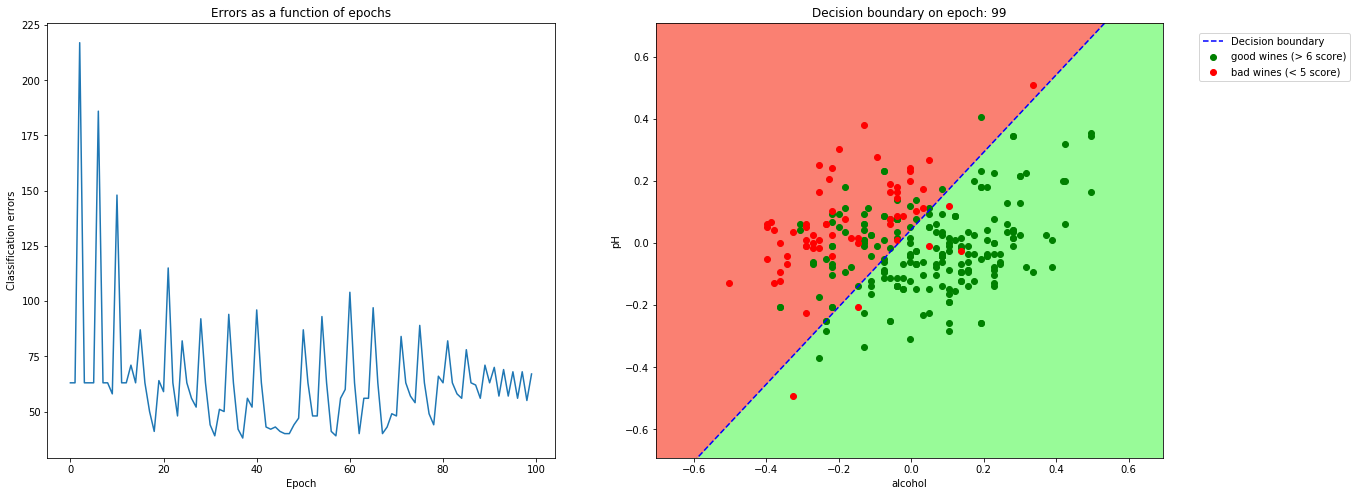

In [45]:
#The lr of 0.5 is too big, adaline makes too many mistakes

fig = plot_performance(train_adaline, selected_data_2, 6, 5, -1, False)
plt.show(fig)

# V.4 Advanced wine sampling and resampling

**a)** Write a function that uses the holdout method to partition the red wine data into a
training and a validation set. The function should take a parameter to adjust the
proportion of training to validation data. It should return a tuple containing:
(training_pandas_dataframe, validation_pandas_dataframe)